# Explore DT

In [34]:
# imports
from importlib import reload
import sys
import h5py
import os
import numpy as np
from scipy import stats

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

#
from ulmo import io as ulmo_io
from ulmo.plotting import plotting

sys.path.append('../')
import scattering

# Load up the full Table

In [3]:
tbl_file = os.path.join(os.getenv('OS_SST'), 'MODIS_L2', 'Tables', 'MODIS_L2_std.parquet')
#tbl_file = os.path.join(os.getenv('OS_SST'), 'MODIS_L2', 'Nenya', 'Tables', 'MODIS_SSL_96clear_v4_DT1.parquet')
modis = ulmo_io.load_main_table(tbl_file)

Read main table: /home/xavier/Projects/Oceanography/SST/MODIS_L2/Tables/MODIS_L2_std.parquet


In [4]:
modis

Index(['lat', 'lon', 'col', 'datetime', 'LL', 'row', 'clear_fraction',
       'mean_temperature', 'Tmin', 'Tmax', 'T90', 'T10', 'filename', 'UID',
       'pp_file', 'pp_root', 'field_size', 'pp_type', 'pp_idx', 'U0', 'U1',
       'zonal_slope', 'merid_slope', 'zonal_slope_err', 'merid_slope_err',
       'DT'],
      dtype='object')

In [6]:
gd = modis_dt1.pp_file == 's3://modis-l2/PreProc/MODIS_R2019_2009_95clear_128x128_preproc_std.h5'
modis_cut = modis[gd].copy()

In [7]:
modis_cut.head()

,lat,lon,col,datetime,LL,row,clear_fraction,mean_temperature,Tmin,Tmax,...,field_size,pp_type,pp_idx,U0,U1,zonal_slope,merid_slope,zonal_slope_err,merid_slope_err,DT
4513079,25.733847,-82.491280,293,2009-12-10 07:05:00,122.362183,1823,0.049500,23.762268,21.510000,25.709999,...,128,0,0,-0.649301,-1.828802,-1.936169,-1.937712,0.172358,0.131554,1.844999
4513080,25.257723,52.965652,261,2009-05-07 22:05:00,167.880432,1232,0.002014,26.484993,25.379999,28.875000,...,128,0,1,0.448978,3.196087,-1.179867,-1.548512,0.158020,0.142136,0.960001
4513081,-14.507998,-25.086424,389,2009-11-18 03:00:00,396.368408,368,0.003174,25.084675,24.035000,26.055000,...,128,0,2,0.921914,4.706947,-0.895917,-1.809518,0.175403,0.160177,0.685001
4513082,-45.345900,-61.669624,325,2009-06-18 04:55:00,268.976807,592,0.019897,8.343443,6.665000,10.145000,...,128,0,3,-2.013854,-0.447833,-1.272257,-2.101485,0.181308,0.119946,1.554999
4513083,20.838291,91.235050,445,2009-10-22 19:35:00,239.789612,1601,0.049744,28.171118,26.855000,29.094999,...,128,0,4,0.957379,2.862641,-1.491272,-1.802350,0.126171,0.185021,0.978094


# Load coeffs

In [8]:
st_coeff_file = os.path.join(os.getenv('OS_SST'), 'MODIS_L2', 'Scattering',
                             'MODIS_2009_ST_coeff.h5')
coeffs = scattering.io.load_coeffs(st_coeff_file)

# Add to Table

In [9]:
for J in range(5):
    modis_cut[f's1_{J}'] = coeffs['S1_iso'][modis_cut.pp_idx, J]

In [19]:
modis_cut['|s1|'] = np.sum(coeffs['S1_iso'][modis_cut.pp_idx,:], axis=1)

In [14]:
modis_cut['max_s1'] = np.max(coeffs['S1_iso'][modis_cut.pp_idx,:], axis=1)

In [21]:
modis_cut['s21'] = coeffs['s21'][modis_cut.pp_idx]
modis_cut['s22'] = coeffs['s22'][modis_cut.pp_idx]

# S1

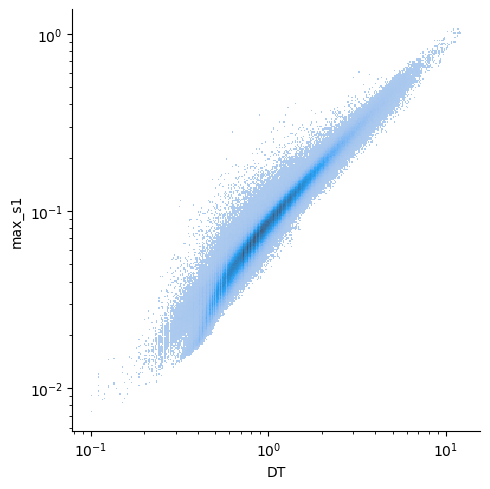

In [16]:
sns.displot(modis_cut, x='DT', y='max_s1', log_scale=True)

## $|s_1|$ looks very similar

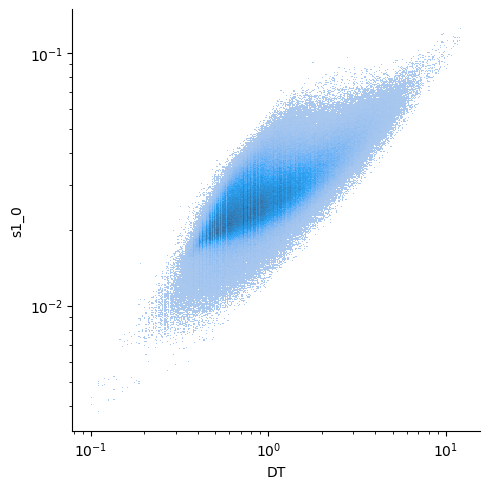

In [42]:
sns.displot(modis_cut, x='DT', y='s1_0', log_scale=True)

### $S1(J=4)$ is nearly identical to the max (because most of the fields have small scale structure dominating)

In [46]:
modis_cut['Ds1'] = modis_cut['s1_4'] / modis_cut['s1_0']

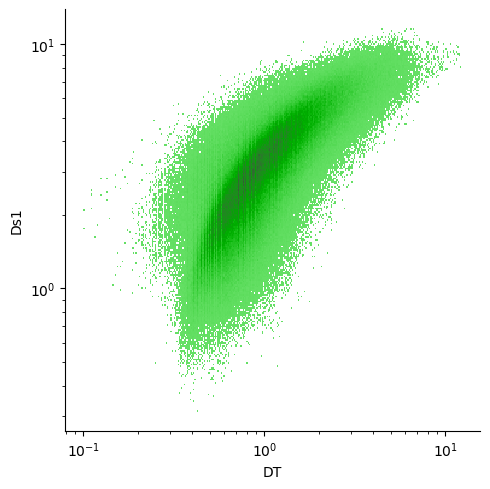

In [47]:
sns.displot(modis_cut, x='DT', y='Ds1', log_scale=True, color='darkgreen')

# S2

In [22]:
lowDT = modis_cut.DT < 0.5
highDT = modis_cut.DT > 2.

## Low $\Delta T$

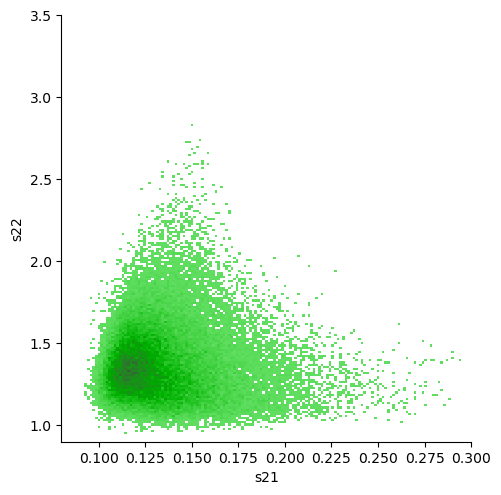

In [27]:
lowfg = sns.displot(modis_cut[lowDT], x='s21', y='s22', color='g')
lowfg.set(xlim=(0.08, 0.3), ylim=(0.9, 3.5))

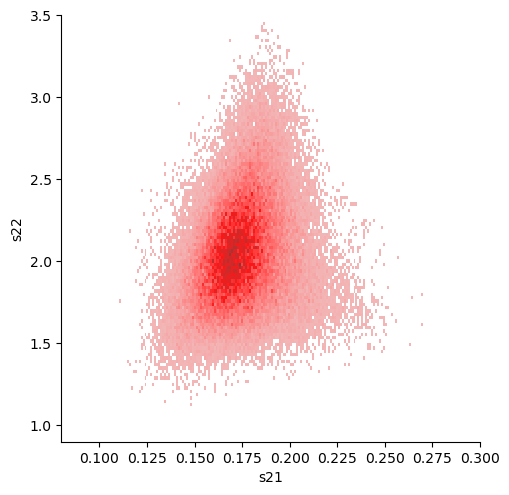

In [29]:
hifg = sns.displot(modis_cut[highDT], x='s21', y='s22', color='r')
hifg.set(xlim=(0.08, 0.3), ylim=(0.9, 3.5))

## 2D histogram

In [36]:
stat, xedges, yedges, _ =\
            stats.binned_statistic_2d(
                modis_cut.s21,
                modis_cut.s22,
                np.log10(modis_cut.DT),
                'median', # 'std', 
    expand_binnumbers=True, bins=[30,30])

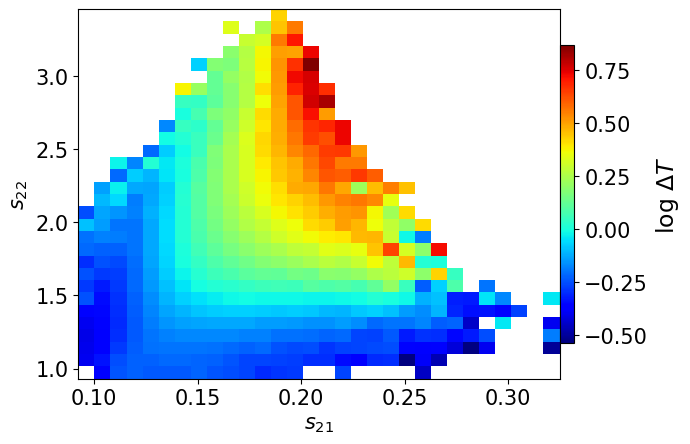

In [41]:
plt.clf()
ax = plt.gca()

cm = plt.get_cmap('jet')
mplt = ax.pcolormesh(xedges, yedges, 
                     stat.transpose(),
                     cmap=cm, 
                     vmax=None) 
# Colorbar
cbaxes = plt.colorbar(mplt, pad=0., fraction=0.030)
cbaxes.set_label(r'$\log \, \Delta T$', fontsize=17.)
cbaxes.ax.tick_params(labelsize=15)

# Label
ax.set_xlabel(r'$s_{21}$')
ax.set_ylabel(r'$s_{22}$')
# Size
plotting.set_fontsize(ax, 15.)
plt.show()